# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 3735552/11490434 [========>.....................] - ETA: 0s

 8413184/11490434 [====================>.........] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 14:06 - loss: 0.6943

  25/1875 [..............................] - ETA: 3s - loss: 0.5712   

  52/1875 [..............................] - ETA: 3s - loss: 0.4835

  79/1875 [>.............................] - ETA: 3s - loss: 0.4377

 107/1875 [>.............................] - ETA: 3s - loss: 0.4079

 134/1875 [=>............................] - ETA: 3s - loss: 0.3875

 162/1875 [=>............................] - ETA: 3s - loss: 0.3712

 191/1875 [==>...........................] - ETA: 3s - loss: 0.3574

 221/1875 [==>...........................] - ETA: 3s - loss: 0.3456

 251/1875 [===>..........................] - ETA: 2s - loss: 0.3355

 276/1875 [===>..........................] - ETA: 2s - loss: 0.3281

 304/1875 [===>..........................] - ETA: 2s - loss: 0.3206

 332/1875 [====>.........................] - ETA: 2s - loss: 0.3140

 358/1875 [====>.........................] - ETA: 2s - loss: 0.3083

 388/1875 [=====>........................] - ETA: 2s - loss: 0.3024

 412/1875 [=====>........................] - ETA: 2s - loss: 0.2980

 436/1875 [=====>........................] - ETA: 2s - loss: 0.2939

 460/1875 [======>.......................] - ETA: 2s - loss: 0.2901

 489/1875 [======>.......................] - ETA: 2s - loss: 0.2858

 516/1875 [=======>......................] - ETA: 2s - loss: 0.2820

 540/1875 [=======>......................] - ETA: 2s - loss: 0.2789

 567/1875 [========>.....................] - ETA: 2s - loss: 0.2755

 599/1875 [========>.....................] - ETA: 2s - loss: 0.2718

 633/1875 [=========>....................] - ETA: 2s - loss: 0.2680

 667/1875 [=========>....................] - ETA: 2s - loss: 0.2646

 700/1875 [==========>...................] - ETA: 2s - loss: 0.2614

 733/1875 [==========>...................] - ETA: 2s - loss: 0.2583

 764/1875 [===========>..................] - ETA: 2s - loss: 0.2557

 799/1875 [===========>..................] - ETA: 1s - loss: 0.2528

 830/1875 [============>.................] - ETA: 1s - loss: 0.2503

 861/1875 [============>.................] - ETA: 1s - loss: 0.2480

 890/1875 [=============>................] - ETA: 1s - loss: 0.2459

 915/1875 [=============>................] - ETA: 1s - loss: 0.2442

 945/1875 [==============>...............] - ETA: 1s - loss: 0.2422

 979/1875 [==============>...............] - ETA: 1s - loss: 0.2400

1012/1875 [===============>..............] - ETA: 1s - loss: 0.2380

1045/1875 [===============>..............] - ETA: 1s - loss: 0.2360

1074/1875 [================>.............] - ETA: 1s - loss: 0.2344

1100/1875 [================>.............] - ETA: 1s - loss: 0.2329

1125/1875 [=================>............] - ETA: 1s - loss: 0.2316

1155/1875 [=================>............] - ETA: 1s - loss: 0.2300

1185/1875 [=================>............] - ETA: 1s - loss: 0.2285

1213/1875 [==================>...........] - ETA: 1s - loss: 0.2271

1243/1875 [==================>...........] - ETA: 1s - loss: 0.2257

1278/1875 [===================>..........] - ETA: 1s - loss: 0.2241

1313/1875 [====================>.........] - ETA: 0s - loss: 0.2225

1343/1875 [====================>.........] - ETA: 0s - loss: 0.2212

1374/1875 [====================>.........] - ETA: 0s - loss: 0.2199

1407/1875 [=====================>........] - ETA: 0s - loss: 0.2186

1431/1875 [=====================>........] - ETA: 0s - loss: 0.2176

1454/1875 [======================>.......] - ETA: 0s - loss: 0.2167

1480/1875 [======================>.......] - ETA: 0s - loss: 0.2157

1507/1875 [=======================>......] - ETA: 0s - loss: 0.2147

1534/1875 [=======================>......] - ETA: 0s - loss: 0.2137

1563/1875 [========================>.....] - ETA: 0s - loss: 0.2127

1592/1875 [========================>.....] - ETA: 0s - loss: 0.2116

1624/1875 [========================>.....] - ETA: 0s - loss: 0.2106

1647/1875 [=========================>....] - ETA: 0s - loss: 0.2098

1675/1875 [=========================>....] - ETA: 0s - loss: 0.2089

1701/1875 [==========================>...] - ETA: 0s - loss: 0.2080



1726/1875 [==========================>...] - ETA: 0s - loss: 0.2072

1752/1875 [===========================>..] - ETA: 0s - loss: 0.2064

1780/1875 [===========================>..] - ETA: 0s - loss: 0.2056

1808/1875 [===========================>..] - ETA: 0s - loss: 0.2047

1837/1875 [============================>.] - ETA: 0s - loss: 0.2039

1865/1875 [============================>.] - ETA: 0s - loss: 0.2031

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2028


Epoch 2/5
   1/1875 [..............................] - ETA: 11s - loss: 0.0986

  30/1875 [..............................] - ETA: 3s - loss: 0.1079 

  58/1875 [..............................] - ETA: 3s - loss: 0.1089

  84/1875 [>.............................] - ETA: 3s - loss: 0.1091

 113/1875 [>.............................] - ETA: 3s - loss: 0.1093

 143/1875 [=>............................] - ETA: 3s - loss: 0.1093

 174/1875 [=>............................] - ETA: 3s - loss: 0.1093

 205/1875 [==>...........................] - ETA: 2s - loss: 0.1093

 237/1875 [==>...........................] - ETA: 2s - loss: 0.1093

 266/1875 [===>..........................] - ETA: 2s - loss: 0.1092

 296/1875 [===>..........................] - ETA: 2s - loss: 0.1091

 326/1875 [====>.........................] - ETA: 2s - loss: 0.1090

 355/1875 [====>.........................] - ETA: 2s - loss: 0.1090

 384/1875 [=====>........................] - ETA: 2s - loss: 0.1089

 409/1875 [=====>........................] - ETA: 2s - loss: 0.1088

 439/1875 [======>.......................] - ETA: 2s - loss: 0.1087

 469/1875 [======>.......................] - ETA: 2s - loss: 0.1087

 500/1875 [=======>......................] - ETA: 2s - loss: 0.1086

 528/1875 [=======>......................] - ETA: 2s - loss: 0.1085

 559/1875 [=======>......................] - ETA: 2s - loss: 0.1084

 585/1875 [========>.....................] - ETA: 2s - loss: 0.1084

 610/1875 [========>.....................] - ETA: 2s - loss: 0.1083

 639/1875 [=========>....................] - ETA: 2s - loss: 0.1082

 663/1875 [=========>....................] - ETA: 2s - loss: 0.1082

 685/1875 [=========>....................] - ETA: 2s - loss: 0.1081

 711/1875 [==========>...................] - ETA: 2s - loss: 0.1081

 736/1875 [==========>...................] - ETA: 2s - loss: 0.1080

 761/1875 [===========>..................] - ETA: 2s - loss: 0.1079

 784/1875 [===========>..................] - ETA: 1s - loss: 0.1079

 807/1875 [===========>..................] - ETA: 1s - loss: 0.1078

 825/1875 [============>.................] - ETA: 1s - loss: 0.1078

 851/1875 [============>.................] - ETA: 1s - loss: 0.1077

 879/1875 [=============>................] - ETA: 1s - loss: 0.1076

 908/1875 [=============>................] - ETA: 1s - loss: 0.1076

 936/1875 [=============>................] - ETA: 1s - loss: 0.1075

 959/1875 [==============>...............] - ETA: 1s - loss: 0.1074

 986/1875 [==============>...............] - ETA: 1s - loss: 0.1074

1008/1875 [===============>..............] - ETA: 1s - loss: 0.1073

1035/1875 [===============>..............] - ETA: 1s - loss: 0.1072

1066/1875 [================>.............] - ETA: 1s - loss: 0.1072

1095/1875 [================>.............] - ETA: 1s - loss: 0.1071

1124/1875 [================>.............] - ETA: 1s - loss: 0.1070

1154/1875 [=================>............] - ETA: 1s - loss: 0.1069

1181/1875 [=================>............] - ETA: 1s - loss: 0.1069

1207/1875 [==================>...........] - ETA: 1s - loss: 0.1068

1234/1875 [==================>...........] - ETA: 1s - loss: 0.1068

1261/1875 [===================>..........] - ETA: 1s - loss: 0.1067

1288/1875 [===================>..........] - ETA: 1s - loss: 0.1066

1314/1875 [====================>.........] - ETA: 1s - loss: 0.1066

1341/1875 [====================>.........] - ETA: 1s - loss: 0.1065

1368/1875 [====================>.........] - ETA: 0s - loss: 0.1064

1393/1875 [=====================>........] - ETA: 0s - loss: 0.1064

1421/1875 [=====================>........] - ETA: 0s - loss: 0.1063

1448/1875 [======================>.......] - ETA: 0s - loss: 0.1063

1470/1875 [======================>.......] - ETA: 0s - loss: 0.1062

1497/1875 [======================>.......] - ETA: 0s - loss: 0.1062

1524/1875 [=======================>......] - ETA: 0s - loss: 0.1061

1551/1875 [=======================>......] - ETA: 0s - loss: 0.1061

1577/1875 [========================>.....] - ETA: 0s - loss: 0.1060

1603/1875 [========================>.....] - ETA: 0s - loss: 0.1060

1630/1875 [=========================>....] - ETA: 0s - loss: 0.1059

1657/1875 [=========================>....] - ETA: 0s - loss: 0.1059

1684/1875 [=========================>....] - ETA: 0s - loss: 0.1058

1707/1875 [==========================>...] - ETA: 0s - loss: 0.1058

1733/1875 [==========================>...] - ETA: 0s - loss: 0.1057

1758/1875 [===========================>..] - ETA: 0s - loss: 0.1057

1784/1875 [===========================>..] - ETA: 0s - loss: 0.1056

1810/1875 [===========================>..] - ETA: 0s - loss: 0.1056

1838/1875 [============================>.] - ETA: 0s - loss: 0.1055

1864/1875 [============================>.] - ETA: 0s - loss: 0.1055

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1055


Epoch 3/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0920

  27/1875 [..............................] - ETA: 3s - loss: 0.0980

  53/1875 [..............................] - ETA: 3s - loss: 0.0982

  79/1875 [>.............................] - ETA: 3s - loss: 0.0981

 103/1875 [>.............................] - ETA: 3s - loss: 0.0980

 130/1875 [=>............................] - ETA: 3s - loss: 0.0980

 156/1875 [=>............................] - ETA: 3s - loss: 0.0979

 182/1875 [=>............................] - ETA: 3s - loss: 0.0979

 210/1875 [==>...........................] - ETA: 3s - loss: 0.0980

 240/1875 [==>...........................] - ETA: 3s - loss: 0.0980

 269/1875 [===>..........................] - ETA: 3s - loss: 0.0980

 298/1875 [===>..........................] - ETA: 2s - loss: 0.0980

 323/1875 [====>.........................] - ETA: 2s - loss: 0.0979

 348/1875 [====>.........................] - ETA: 2s - loss: 0.0979

 373/1875 [====>.........................] - ETA: 2s - loss: 0.0979

 399/1875 [=====>........................] - ETA: 2s - loss: 0.0979

 417/1875 [=====>........................] - ETA: 2s - loss: 0.0979

 441/1875 [======>.......................] - ETA: 2s - loss: 0.0978

 467/1875 [======>.......................] - ETA: 2s - loss: 0.0978

 494/1875 [======>.......................] - ETA: 2s - loss: 0.0978

 519/1875 [=======>......................] - ETA: 2s - loss: 0.0978

 545/1875 [=======>......................] - ETA: 2s - loss: 0.0977

 566/1875 [========>.....................] - ETA: 2s - loss: 0.0977

 589/1875 [========>.....................] - ETA: 2s - loss: 0.0977

 614/1875 [========>.....................] - ETA: 2s - loss: 0.0977

 638/1875 [=========>....................] - ETA: 2s - loss: 0.0977

 663/1875 [=========>....................] - ETA: 2s - loss: 0.0977

 690/1875 [==========>...................] - ETA: 2s - loss: 0.0976

 717/1875 [==========>...................] - ETA: 2s - loss: 0.0976

 739/1875 [==========>...................] - ETA: 2s - loss: 0.0976

 761/1875 [===========>..................] - ETA: 2s - loss: 0.0976

 786/1875 [===========>..................] - ETA: 2s - loss: 0.0976

 812/1875 [===========>..................] - ETA: 2s - loss: 0.0976

 836/1875 [============>.................] - ETA: 2s - loss: 0.0976

 858/1875 [============>.................] - ETA: 2s - loss: 0.0976

 883/1875 [=============>................] - ETA: 2s - loss: 0.0976

 909/1875 [=============>................] - ETA: 1s - loss: 0.0975

 934/1875 [=============>................] - ETA: 1s - loss: 0.0975

 960/1875 [==============>...............] - ETA: 1s - loss: 0.0975

 984/1875 [==============>...............] - ETA: 1s - loss: 0.0975

1010/1875 [===============>..............] - ETA: 1s - loss: 0.0975

1036/1875 [===============>..............] - ETA: 1s - loss: 0.0975

1058/1875 [===============>..............] - ETA: 1s - loss: 0.0975

1083/1875 [================>.............] - ETA: 1s - loss: 0.0975

1107/1875 [================>.............] - ETA: 1s - loss: 0.0975

1135/1875 [=================>............] - ETA: 1s - loss: 0.0975

1160/1875 [=================>............] - ETA: 1s - loss: 0.0974

1184/1875 [=================>............] - ETA: 1s - loss: 0.0974

1211/1875 [==================>...........] - ETA: 1s - loss: 0.0974

1236/1875 [==================>...........] - ETA: 1s - loss: 0.0974

1260/1875 [===================>..........] - ETA: 1s - loss: 0.0974

1283/1875 [===================>..........] - ETA: 1s - loss: 0.0974

1307/1875 [===================>..........] - ETA: 1s - loss: 0.0974

1333/1875 [====================>.........] - ETA: 1s - loss: 0.0974

1361/1875 [====================>.........] - ETA: 1s - loss: 0.0974

1392/1875 [=====================>........] - ETA: 0s - loss: 0.0974

1424/1875 [=====================>........] - ETA: 0s - loss: 0.0974

1451/1875 [======================>.......] - ETA: 0s - loss: 0.0974

1479/1875 [======================>.......] - ETA: 0s - loss: 0.0973

1508/1875 [=======================>......] - ETA: 0s - loss: 0.0973

1534/1875 [=======================>......] - ETA: 0s - loss: 0.0973

1561/1875 [=======================>......] - ETA: 0s - loss: 0.0973

1589/1875 [========================>.....] - ETA: 0s - loss: 0.0973

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0973

1626/1875 [=========================>....] - ETA: 0s - loss: 0.0973

1653/1875 [=========================>....] - ETA: 0s - loss: 0.0973

1680/1875 [=========================>....] - ETA: 0s - loss: 0.0973

1704/1875 [==========================>...] - ETA: 0s - loss: 0.0973

1727/1875 [==========================>...] - ETA: 0s - loss: 0.0973

1751/1875 [===========================>..] - ETA: 0s - loss: 0.0973

1774/1875 [===========================>..] - ETA: 0s - loss: 0.0973

1797/1875 [===========================>..] - ETA: 0s - loss: 0.0973

1813/1875 [============================>.] - ETA: 0s - loss: 0.0973

1838/1875 [============================>.] - ETA: 0s - loss: 0.0972

1862/1875 [============================>.] - ETA: 0s - loss: 0.0972

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0972


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1008

  25/1875 [..............................] - ETA: 3s - loss: 0.0950

  53/1875 [..............................] - ETA: 3s - loss: 0.0948

  75/1875 [>.............................] - ETA: 3s - loss: 0.0951

  99/1875 [>.............................] - ETA: 3s - loss: 0.0951

 129/1875 [=>............................] - ETA: 3s - loss: 0.0952

 151/1875 [=>............................] - ETA: 3s - loss: 0.0953

 173/1875 [=>............................] - ETA: 3s - loss: 0.0954

 197/1875 [==>...........................] - ETA: 3s - loss: 0.0954

 220/1875 [==>...........................] - ETA: 3s - loss: 0.0954

 247/1875 [==>...........................] - ETA: 3s - loss: 0.0954

 273/1875 [===>..........................] - ETA: 3s - loss: 0.0955

 299/1875 [===>..........................] - ETA: 3s - loss: 0.0955

 321/1875 [====>.........................] - ETA: 3s - loss: 0.0955

 345/1875 [====>.........................] - ETA: 3s - loss: 0.0955

 373/1875 [====>.........................] - ETA: 3s - loss: 0.0955

 396/1875 [=====>........................] - ETA: 3s - loss: 0.0955

 420/1875 [=====>........................] - ETA: 2s - loss: 0.0955

 445/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 468/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 492/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 514/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 543/1875 [=======>......................] - ETA: 2s - loss: 0.0956

 568/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 595/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 623/1875 [========>.....................] - ETA: 2s - loss: 0.0956

 652/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 679/1875 [=========>....................] - ETA: 2s - loss: 0.0956

 707/1875 [==========>...................] - ETA: 2s - loss: 0.0956

 734/1875 [==========>...................] - ETA: 2s - loss: 0.0956

 762/1875 [===========>..................] - ETA: 2s - loss: 0.0956

 791/1875 [===========>..................] - ETA: 2s - loss: 0.0956

 817/1875 [============>.................] - ETA: 2s - loss: 0.0956

 844/1875 [============>.................] - ETA: 2s - loss: 0.0956

 871/1875 [============>.................] - ETA: 2s - loss: 0.0956

 898/1875 [=============>................] - ETA: 1s - loss: 0.0956

 925/1875 [=============>................] - ETA: 1s - loss: 0.0956

 953/1875 [==============>...............] - ETA: 1s - loss: 0.0956

 977/1875 [==============>...............] - ETA: 1s - loss: 0.0956

1005/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1031/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1059/1875 [===============>..............] - ETA: 1s - loss: 0.0956

1086/1875 [================>.............] - ETA: 1s - loss: 0.0956

1114/1875 [================>.............] - ETA: 1s - loss: 0.0956

1141/1875 [=================>............] - ETA: 1s - loss: 0.0956

1164/1875 [=================>............] - ETA: 1s - loss: 0.0956

1189/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1215/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1241/1875 [==================>...........] - ETA: 1s - loss: 0.0956

1266/1875 [===================>..........] - ETA: 1s - loss: 0.0956

1293/1875 [===================>..........] - ETA: 1s - loss: 0.0956

1319/1875 [====================>.........] - ETA: 1s - loss: 0.0956

1346/1875 [====================>.........] - ETA: 1s - loss: 0.0956

1374/1875 [====================>.........] - ETA: 0s - loss: 0.0956

1397/1875 [=====================>........] - ETA: 0s - loss: 0.0956

1422/1875 [=====================>........] - ETA: 0s - loss: 0.0956

1443/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1466/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1488/1875 [======================>.......] - ETA: 0s - loss: 0.0956

1504/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1528/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1553/1875 [=======================>......] - ETA: 0s - loss: 0.0956

1575/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1600/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1622/1875 [========================>.....] - ETA: 0s - loss: 0.0956

1648/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1671/1875 [=========================>....] - ETA: 0s - loss: 0.0956

1697/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1716/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1739/1875 [==========================>...] - ETA: 0s - loss: 0.0956

1763/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1786/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1809/1875 [===========================>..] - ETA: 0s - loss: 0.0956

1836/1875 [============================>.] - ETA: 0s - loss: 0.0956

1856/1875 [============================>.] - ETA: 0s - loss: 0.0956

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0956


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1044

  26/1875 [..............................] - ETA: 3s - loss: 0.0962

  54/1875 [..............................] - ETA: 3s - loss: 0.0959

  81/1875 [>.............................] - ETA: 3s - loss: 0.0959

 108/1875 [>.............................] - ETA: 3s - loss: 0.0958

 130/1875 [=>............................] - ETA: 3s - loss: 0.0958

 153/1875 [=>............................] - ETA: 3s - loss: 0.0958

 170/1875 [=>............................] - ETA: 3s - loss: 0.0958

 193/1875 [==>...........................] - ETA: 3s - loss: 0.0958

 221/1875 [==>...........................] - ETA: 3s - loss: 0.0958

 248/1875 [==>...........................] - ETA: 3s - loss: 0.0958

 276/1875 [===>..........................] - ETA: 3s - loss: 0.0957

 304/1875 [===>..........................] - ETA: 3s - loss: 0.0957

 326/1875 [====>.........................] - ETA: 3s - loss: 0.0956

 349/1875 [====>.........................] - ETA: 3s - loss: 0.0956

 376/1875 [=====>........................] - ETA: 3s - loss: 0.0956

 399/1875 [=====>........................] - ETA: 3s - loss: 0.0955

 426/1875 [=====>........................] - ETA: 2s - loss: 0.0955

 449/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 471/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 493/1875 [======>.......................] - ETA: 2s - loss: 0.0955

 518/1875 [=======>......................] - ETA: 2s - loss: 0.0955

 539/1875 [=======>......................] - ETA: 2s - loss: 0.0954

 565/1875 [========>.....................] - ETA: 2s - loss: 0.0954

 583/1875 [========>.....................] - ETA: 2s - loss: 0.0954

 607/1875 [========>.....................] - ETA: 2s - loss: 0.0954

 630/1875 [=========>....................] - ETA: 2s - loss: 0.0954

 651/1875 [=========>....................] - ETA: 2s - loss: 0.0954

 676/1875 [=========>....................] - ETA: 2s - loss: 0.0954

 703/1875 [==========>...................] - ETA: 2s - loss: 0.0954

 729/1875 [==========>...................] - ETA: 2s - loss: 0.0954

 751/1875 [===========>..................] - ETA: 2s - loss: 0.0954

 777/1875 [===========>..................] - ETA: 2s - loss: 0.0953

 796/1875 [===========>..................] - ETA: 2s - loss: 0.0953

 821/1875 [============>.................] - ETA: 2s - loss: 0.0953

 843/1875 [============>.................] - ETA: 2s - loss: 0.0953

 867/1875 [============>.................] - ETA: 2s - loss: 0.0953

 894/1875 [=============>................] - ETA: 2s - loss: 0.0953

 921/1875 [=============>................] - ETA: 2s - loss: 0.0953

 947/1875 [==============>...............] - ETA: 1s - loss: 0.0953

 974/1875 [==============>...............] - ETA: 1s - loss: 0.0953

1002/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1023/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1049/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1074/1875 [================>.............] - ETA: 1s - loss: 0.0953

1098/1875 [================>.............] - ETA: 1s - loss: 0.0953

1123/1875 [================>.............] - ETA: 1s - loss: 0.0953

1151/1875 [=================>............] - ETA: 1s - loss: 0.0953

1177/1875 [=================>............] - ETA: 1s - loss: 0.0953

1204/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1232/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1259/1875 [===================>..........] - ETA: 1s - loss: 0.0953

1287/1875 [===================>..........] - ETA: 1s - loss: 0.0952

1315/1875 [====================>.........] - ETA: 1s - loss: 0.0952

1343/1875 [====================>.........] - ETA: 1s - loss: 0.0952

1370/1875 [====================>.........] - ETA: 1s - loss: 0.0952

1391/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1419/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1447/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1473/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1500/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1528/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1555/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1583/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1611/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1639/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1664/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1689/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1716/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1745/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1773/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1803/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1828/1875 [============================>.] - ETA: 0s - loss: 0.0952

1857/1875 [============================>.] - ETA: 0s - loss: 0.0952

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0952


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

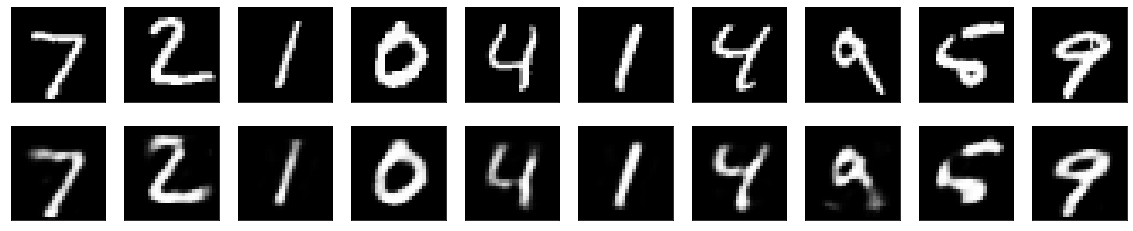

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
